In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='dark')
from scipy.stats import zscore
from itertools import product

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, f1_score,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report,accuracy_score, precision_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier

In [3]:
raw_data = pd.read_csv('Train_clean.csv')
raw_data

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Room_Num,Side,num_ameneties,top_amenities
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False,B,0.0,P,0,None
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,4.700480,2.302585,3.258097,6.309918,3.806662,Juanna Vines,True,F,0.0,S,5,Spa
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,3.784190,8.182280,0.000000,8.812248,3.912023,Altark Susent,False,A,0.0,S,4,Spa
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.000000,7.157735,5.918894,8.110728,5.267858,Solam Susent,False,A,0.0,S,4,Spa
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,5.717028,4.262680,5.023881,6.338594,1.098612,Willy Santantines,True,F,1.0,S,5,Spa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,55 Cancri e,41.0,True,0.000000,8.827615,0.000000,7.404888,4.317488,Gravior Noxnuther,False,A,98.0,P,3,FoodCourt
8689,9278_01,Earth,True,PSO J318.5-22,18.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,Kurta Mondalley,False,G,1499.0,S,0,None
8690,9279_01,Earth,False,TRAPPIST-1e,26.0,False,0.000000,0.000000,7.535297,0.693147,0.000000,Fayey Connon,True,G,1500.0,S,2,ShoppingMall
8691,9280_01,Europa,False,55 Cancri e,32.0,False,0.000000,6.956545,0.000000,5.869297,8.082093,Celeon Hontichre,False,E,608.0,S,3,VRDeck


In [4]:
raw_test = pd.read_csv('Test_clean.csv')

In [5]:
raw_data.set_index('PassengerId',inplace=True)
raw_test.set_index('PassengerId',inplace=True)
train_indices = raw_data.index
test_indices = raw_test.index
test_indices

Index(['0013_01', '0018_01', '0019_01', '0021_01', '0023_01', '0027_01',
       '0029_01', '0032_01', '0032_02', '0033_01',
       ...
       '9260_01', '9262_01', '9263_01', '9265_01', '9266_01', '9266_02',
       '9269_01', '9271_01', '9273_01', '9277_01'],
      dtype='object', name='PassengerId', length=4277)

#### For the model building section I will begin with feature preprocessing:
##### Scaling: The features are already log transformed, however Age & Romm_num are not. For all of them I will use MinMax Scaler to preserve the underlying pattern. Alternatively I will try normalizing using z-score normalization
##### Categorical features: 
- Homeplanet & Destination have 3 unique categories so I will hot-one encode
- Cryosleep & VIP are boolean features so I will binary encode
- Cabin info('Deck' - 8 unique & 'Side' - 2) we will use dummy variables from pandas
#### Model Selection: MLP classification & Decision-Tree for understanding the important features (sklearn)
- I will start with the decision tree to understand the impact on the model building to see if different scaling/normalization technique
- I will build the MLP model and then tune it after based on the accuracy, F1 score & precision.

In [6]:
raw_test.drop(columns='Transported',inplace=True)

In [7]:
df = raw_data.copy()
df.sample(15)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Room_Num,Side,num_ameneties,top_amenities
PassengerId,,,,,,,,,,,,,,,,,
4446_01,Europa,False,TRAPPIST-1e,38.0,False,1.098612,4.744932,6.648985,8.037543,6.107023,Asellan Chocaters,False,B,175.0,S,5,Spa
3815_01,Earth,False,TRAPPIST-1e,23.0,False,0.000000,0.000000,0.000000,6.586172,4.394449,Tarah Patteraley,False,F,787.0,P,2,Spa
7058_01,Mars,True,55 Cancri e,30.0,False,0.000000,0.000000,1.646834,0.000000,0.000000,Hal Bane,True,F,1347.0,S,0,RoomService
4927_03,Mars,False,TRAPPIST-1e,20.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,Naffsh Brele,True,F,937.0,S,0,None
4003_01,Earth,False,TRAPPIST-1e,22.0,False,7.257003,0.000000,0.000000,0.000000,0.000000,Alasmon Meteet,True,F,827.0,P,1,RoomService
3195_06,Earth,True,TRAPPIST-1e,9.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,Violan Litthews,False,G,505.0,S,0,None
3547_01,Mars,False,55 Cancri e,21.0,False,7.003065,1.944776,7.507141,0.000000,0.000000,Smarve Canie,False,D,112.0,S,2,ShoppingMall
9008_01,Earth,False,TRAPPIST-1e,31.0,False,0.000000,5.159055,6.016157,4.634729,3.784190,Robina Herreras,False,F,1745.0,S,4,ShoppingMall
5927_01,Europa,False,55 Cancri e,24.0,False,0.000000,7.792349,0.000000,6.587550,7.741099,Duhrak Sysilstict,False,B,201.0,P,3,FoodCourt


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     8693 non-null   object 
 1   CryoSleep      8693 non-null   bool   
 2   Destination    8693 non-null   object 
 3   Age            8693 non-null   float64
 4   VIP            8693 non-null   bool   
 5   RoomService    8693 non-null   float64
 6   FoodCourt      8693 non-null   float64
 7   ShoppingMall   8693 non-null   float64
 8   Spa            8693 non-null   float64
 9   VRDeck         8693 non-null   float64
 10  Name           8693 non-null   object 
 11  Transported    8693 non-null   bool   
 12  Deck           8693 non-null   object 
 13  Room_Num       8693 non-null   float64
 14  Side           8693 non-null   object 
 15  num_ameneties  8693 non-null   int64  
 16  top_amenities  8693 non-null   object 
dtypes: bool(3), float64(7), int64(1), object(6)
memo

In [9]:
scaler = MinMaxScaler()
numerical_features = df.select_dtypes(include=['float64','int64']).columns
df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_features]),columns=numerical_features,index=df.index)
df_scaled

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Room_Num,num_ameneties
PassengerId,,,,,,,,
0001_01,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
0002_01,0.303797,0.491170,0.223493,0.323723,0.629907,0.377219,0.000000,1.0
0003_01,0.734177,0.395423,0.794185,0.000000,0.879710,0.387660,0.000000,0.8
0003_02,0.417722,0.000000,0.694741,0.588099,0.809679,0.522016,0.000000,0.8
0004_01,0.202532,0.597392,0.413743,0.499171,0.632770,0.108866,0.000528,1.0
...,...,...,...,...,...,...,...,...
9276_01,0.518987,0.000000,0.856823,0.000000,0.739216,0.427839,0.051742,0.6
9278_01,0.227848,0.000000,0.000000,0.000000,0.000000,0.000000,0.791447,0.0
9279_01,0.329114,0.000000,0.000000,0.748704,0.069196,0.000000,0.791975,0.4


In [10]:
label = LabelEncoder()
label_features = ['CryoSleep','VIP','Deck','Side']
df_encoded = pd.DataFrame(df[label_features],columns=label_features,index=df.index)
for feature in label_features:    
    df_encoded[feature] = label.fit_transform(df_encoded[feature])
    
df_encoded

,CryoSleep,VIP,Deck,Side
PassengerId,,,,
0001_01,0,0,1,0
0002_01,0,0,5,1
0003_01,0,1,0,1
0003_02,0,0,0,1
0004_01,0,0,5,1
...,...,...,...,...
9276_01,0,1,0,0
9278_01,1,0,6,1
9279_01,0,0,6,1


In [11]:
ohe = OneHotEncoder()
ohe_features = ['HomePlanet','Destination','top_amenities']
df_ohe = pd.DataFrame(ohe.fit_transform(df[ohe_features]).toarray(),columns=ohe.get_feature_names_out(),index=df.index)
df_ohe

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,top_amenities_FoodCourt,top_amenities_None,top_amenities_RoomService,top_amenities_ShoppingMall,top_amenities_Spa,top_amenities_VRDeck
PassengerId,,,,,,,,,,,,
0001_01,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
0002_01,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
0003_01,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
0003_02,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
0004_01,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9276_01,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9278_01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9279_01,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
features = pd.concat([df_scaled,df_encoded,df_ohe],axis=1)
targets = label.fit_transform(df['Transported'])
targets

array([0, 1, 0, ..., 1, 0, 1], dtype=int64)

We need to ensure we do the same for the test data


In [13]:
test_df = raw_test.copy()
test_df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Room_Num,Side,num_ameneties,top_amenities
PassengerId,,,,,,,,,,,,,,,,
0013_01,Earth,True,TRAPPIST-1e,27.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,Nelly Carsoning,G,3.0,S,0,None
0018_01,Earth,False,TRAPPIST-1e,19.0,False,0.000000,2.302585,0.000000,7.945910,0.000000,Lerome Peckers,F,4.0,S,2,Spa
0019_01,Europa,True,55 Cancri e,31.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,Sabih Unhearfus,C,0.0,S,0,None
0021_01,Europa,False,TRAPPIST-1e,38.0,False,0.000000,8.802823,0.000000,5.204007,6.373320,Meratz Caltilter,C,1.0,S,3,FoodCourt
0023_01,Earth,False,TRAPPIST-1e,20.0,False,2.397895,0.000000,6.455199,0.000000,0.000000,Brence Harperez,F,5.0,S,2,ShoppingMall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,Earth,True,TRAPPIST-1e,34.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,Jeron Peter,G,1496.0,S,0,None
9269_01,Earth,False,TRAPPIST-1e,42.0,False,0.000000,6.742881,2.890372,2.397895,4.976734,Matty Scheron,F,431.0,S,4,FoodCourt
9271_01,Mars,True,55 Cancri e,27.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,Jayrin Pore,D,296.0,P,0,None


In [14]:
numerical_features = test_df.select_dtypes(include=['float64','int64']).columns
test_scaled = pd.DataFrame(scaler.fit_transform(test_df[numerical_features]),columns=numerical_features,index=test_df.index)
print(test_scaled.shape)
label_features = ['CryoSleep','VIP','Deck','Side']
test_encoded = pd.DataFrame(test_df[label_features],columns=label_features,index=test_df.index)
for feature in label_features:    
    test_encoded[feature] = label.fit_transform(test_encoded[feature])
print(test_encoded.shape)
ohe_features = ['HomePlanet','Destination','top_amenities']
test_ohe = pd.DataFrame(ohe.fit_transform(test_df[ohe_features]).toarray(),columns=ohe.get_feature_names_out(),index=test_df.index)
print(test_ohe.shape)
test_features = pd.concat([test_scaled,test_encoded,test_ohe],axis=1)
test_features

(4277, 8)
(4277, 4)
(4277, 12)


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Room_Num,num_ameneties,CryoSleep,VIP,...,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,top_amenities_FoodCourt,top_amenities_None,top_amenities_RoomService,top_amenities_ShoppingMall,top_amenities_Spa,top_amenities_VRDeck
PassengerId,,,,,,,,,,,,,,,,,,,,,
0013_01,0.341772,0.000000,0.000000,0.000000,0.000000,0.000000,0.001587,0.0,1,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
0018_01,0.240506,0.000000,0.227135,0.000000,0.802965,0.000000,0.002116,0.4,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
0019_01,0.392405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0021_01,0.481013,0.000000,0.868340,0.000000,0.525885,0.636623,0.000529,0.6,0,0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
0023_01,0.253165,0.256295,0.000000,0.715403,0.000000,0.000000,0.002646,0.4,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,0.430380,0.000000,0.000000,0.000000,0.000000,0.000000,0.791534,0.0,1,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
9269_01,0.531646,0.000000,0.665140,0.320328,0.242317,0.497120,0.228042,0.8,0,0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
9271_01,0.341772,0.000000,0.000000,0.000000,0.000000,0.000000,0.156614,0.0,1,0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Model Building
This section will be comprised of 2 parts, Decision Tree and Multi-layer perceptrons
#### 1. Decision Tree Classifier
- Build a basic decision tree to get a base score from which we will tune and get the best parameters. 
- We will extract the feature importance from the basic tree to see if we are justified in our feature engineering methodologies, especially for the feature we introduced ourselves
- Fine tune the hyperparameters and get a final model to fit onto the entire dataset and get the final feature importance measurements

#### 2. MLP Classifier
Multi-layer perceptrons are nueral network models from sci-kit learn's library
- Similar to the decision tree, we will build a basic MLP model however we will not be extracting weights at this stage as the objective at this step is to get the maximum accuracy & F1 score possible
- We will implement GridSearch and Cross-validation techniques to get the best score possible and find the hyperparameter there
- We will then implement the final model onto the entire dataset and then extract weights to see which features played a significant role in determining the class differenciation 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features,targets, test_size=0.2, random_state=0)

##### First step is to build a simple model to obtain a base score from which to tune from

In [16]:
clf = DecisionTreeClassifier(
                            criterion='log_loss',
                            splitter='best',
                            #max_depth=10,
                            #max_leaf_nodes=50,
                            #min_samples_leaf=10,
                            #max_features='auto',
                            #ccp_alpha=0.01,
                            random_state=0
                            )
clf.fit(X_train,y_train)


DecisionTreeClassifier(criterion='log_loss', random_state=0)

In [17]:
y_pred = clf.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test,y_pred):.4f}')
print(f'Precision Score:{ precision_score(y_test,y_pred):.4f}')
print(f'F1 Score: {f1_score(y_test,y_pred):.4f}')
print('-------------------------------------------------')
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix :')
print(cm)
print('-------------------------------------------------')
print("Tree depth =",clf.get_depth(),'\n'
      "Number of leaves =",clf.get_n_leaves())


Accuracy Score: 0.7585
Precision Score:0.7591
F1 Score: 0.7608
-------------------------------------------------
Confusion Matrix :
[[651 212]
 [208 668]]
-------------------------------------------------
Tree depth = 39 
Number of leaves = 1244


[Text(0.5, 0.875, 'num_ameneties <= 0.1\nlog_loss = 1.0\nsamples = 6954\nvalue = [3452, 3502]\nclass = True'),
 Text(0.25, 0.625, 'HomePlanet_Earth <= 0.5\nlog_loss = 0.743\nsamples = 2916\nvalue = [615, 2301]\nclass = True'),
 Text(0.125, 0.375, 'CryoSleep <= 0.5\nlog_loss = 0.356\nsamples = 1467\nvalue = [99, 1368]\nclass = True'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'Side <= 0.5\nlog_loss = 0.939\nsamples = 1449\nvalue = [516, 933]\nclass = True'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'top_amenities_FoodCourt <= 0.5\nlog_loss = 0.878\nsamples = 4038\nvalue = [2837, 1201]\nclass = False'),
 Text(0.625, 0.375, 'top_amenities_ShoppingMall <= 0.5\nlog_loss = 0.756\nsamples = 3147\nvalue = [2461, 686]\nclass = False'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'FoodCourt <= 0.736\nlog_loss = 0.982\nsamples = 891\

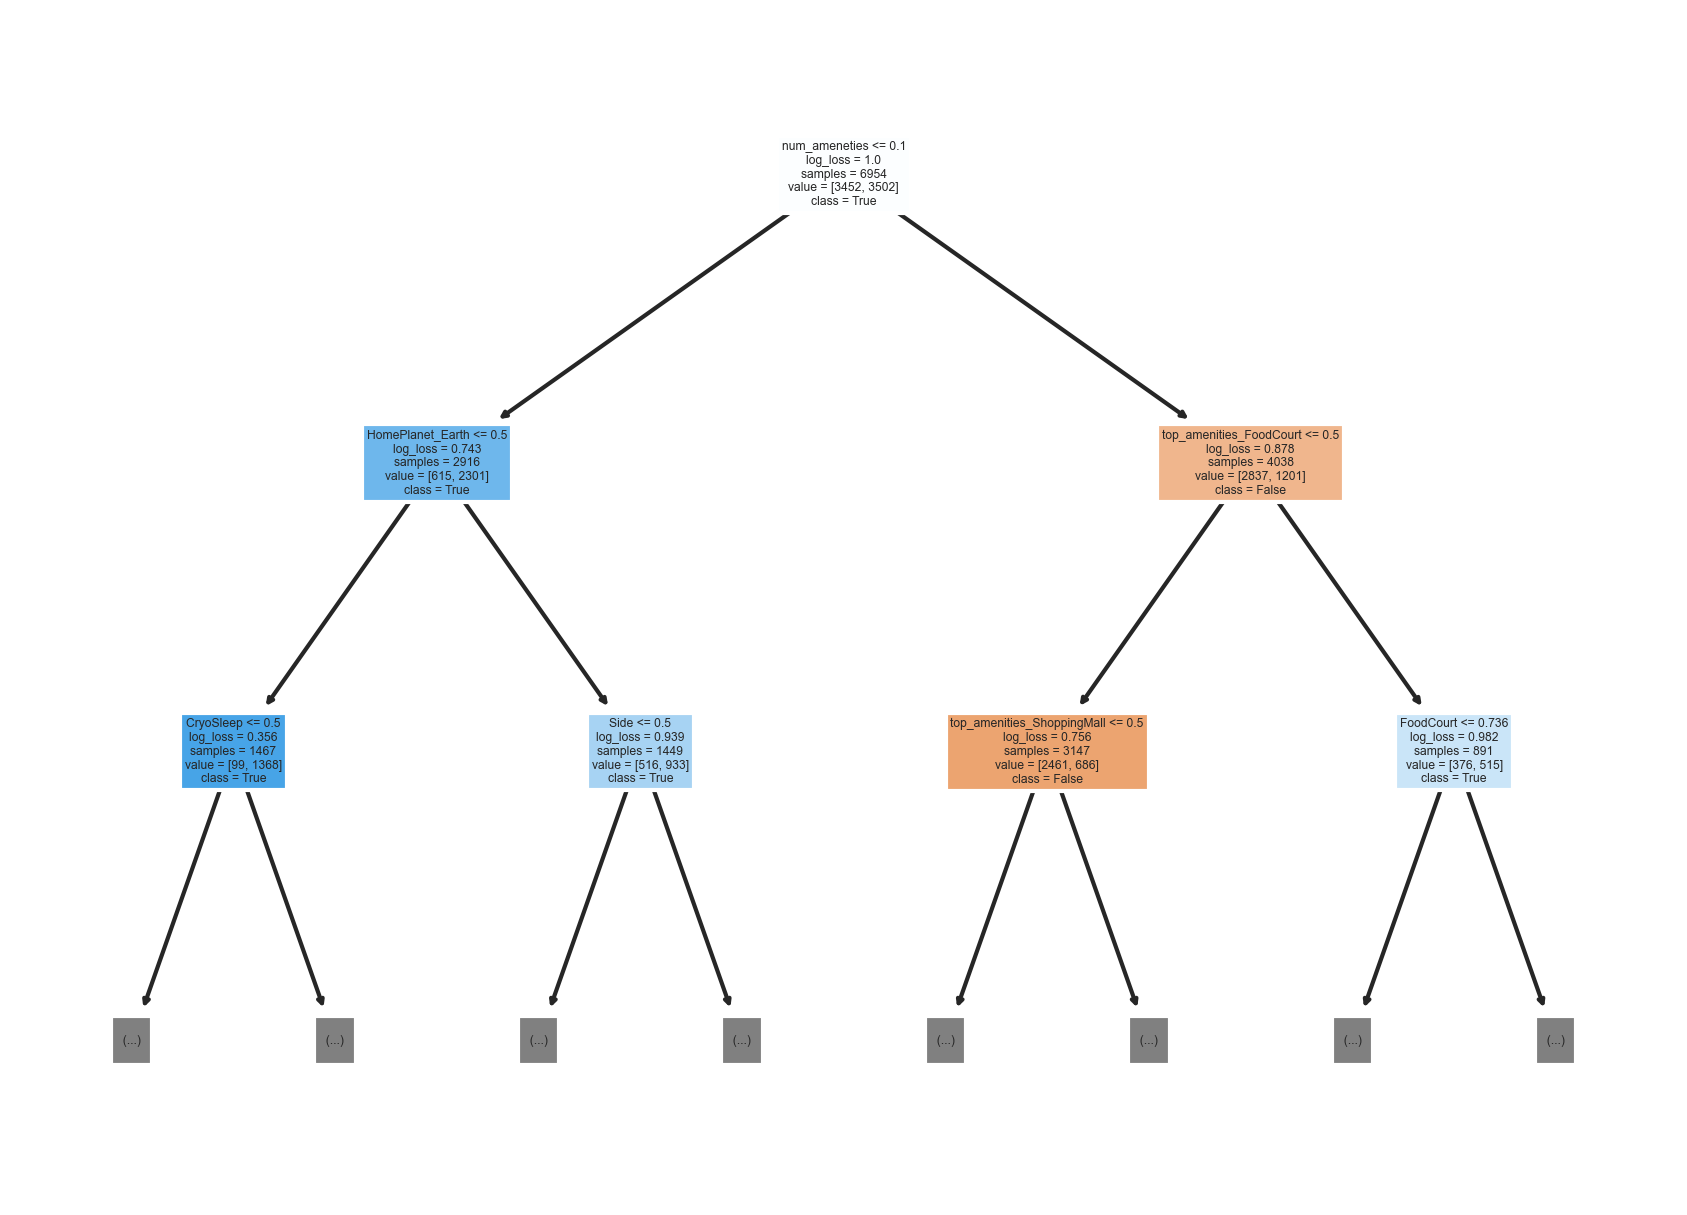

In [18]:
tree_feature_names=X_test.columns
plt.figure(figsize=[7,5], dpi=300)
plot_tree(clf, feature_names=tree_feature_names, filled=True,max_depth=2,class_names=df.Transported.values.astype(str))

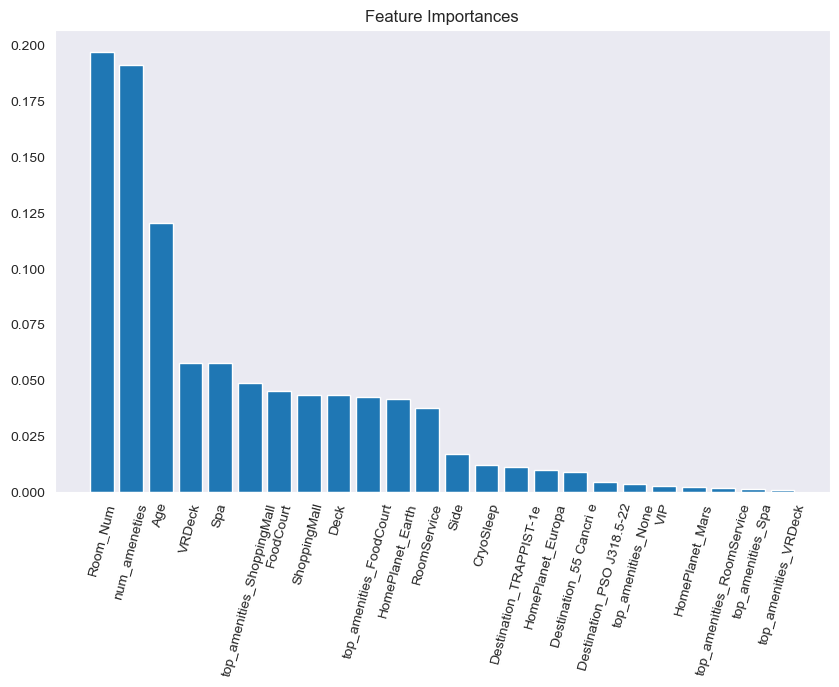

In [19]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=75)
plt.title("Feature Importances")
plt.show()

First set of parameters to tune is those we used to see if the selection method is the best

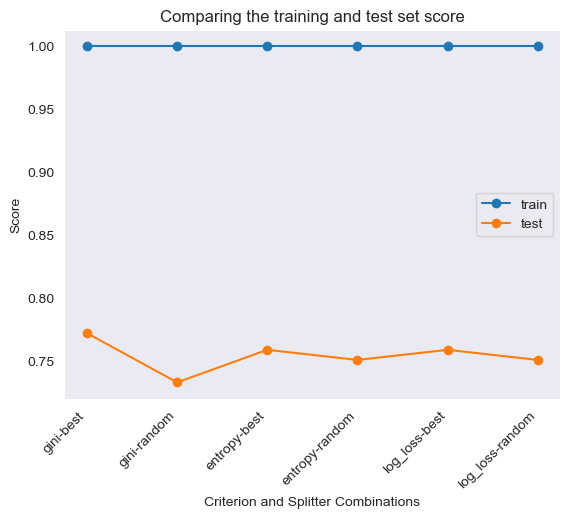

In [20]:
criterions = ['gini','entropy','log_loss']
splitters = ['best','random']
clfs = []
for crits in criterions:
    for splits in splitters:
        clf2 = DecisionTreeClassifier(random_state=0, criterion=crits, splitter=splits)
        clf2.fit(X_train, y_train)
        clfs.append(clf2)
    
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

# Plot the results
fig, ax = plt.subplots()
ax.set_xlabel("Criterion and Splitter Combinations")
ax.set_ylabel("Score")
ax.set_title("Comparing the training and test set score")

# Use labels that represent the combination of criterion and splitter
labels = [f"{criterion}-{splitter}" for criterion in criterions for splitter in splitters]

ax.plot(labels, train_scores, marker='o', label="train")
ax.plot(labels, test_scores, marker='o', label="test")
ax.legend()
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

##### Our best combo is gini & best
##### we now want to know how greedy to allow the tree to be

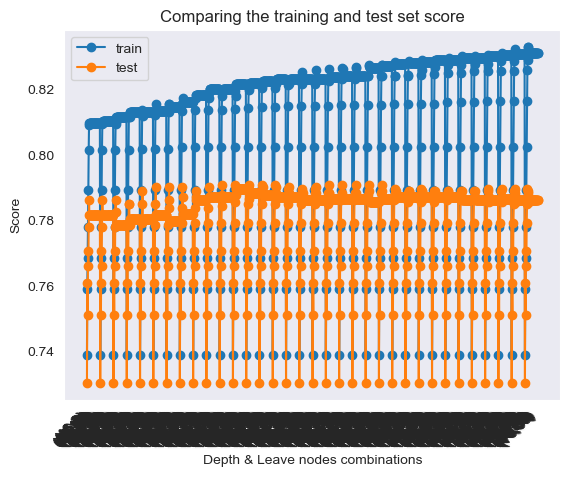

In [21]:
# Finding the optimal number of leaf nodes
nodes = [node for node in range(46,80)]     
depths = [depth for depth in range(1,39)]
clfs = []
for node in nodes:
    for depth in depths:
        clf = DecisionTreeClassifier(random_state=0,
                                      criterion='gini',
                                      splitter='best',
                                      max_leaf_nodes=node,
                                      max_depth=depth
                                    )
        clf.fit(X_train, y_train)
        clfs.append(clf)
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

# Plot the results
fig, ax = plt.subplots()
ax.set_xlabel("Depth & Leave nodes combinations")
ax.set_ylabel("Score")
ax.set_title("Comparing the training and test set score")

labels = [f"({node},{depth})" for node in nodes for depth in depths]

ax.plot(labels, train_scores, marker='o', label="train")
ax.plot(labels, test_scores, marker='o', label="test")
ax.legend()
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

In [22]:
best_score_index = np.argmax(test_scores)
best_params = {
    'max_leaf_nodes': nodes[best_score_index // len(depths)],
    'max_depth': depths[best_score_index % len(depths)]
}
print("Best Parameters:", best_params)

Best Parameters: {'max_leaf_nodes': 56, 'max_depth': 8}


In [23]:
best_score_index = np.argmax(test_scores)
best_params = {
    'max_leaf_nodes': nodes[best_score_index // len(depths)],
    'max_depth': depths[best_score_index % len(depths)]
}
print("Best Parameters:", best_params)

Best Parameters: {'max_leaf_nodes': 56, 'max_depth': 8}


Now we want to know if regularization will improve the score for our tree

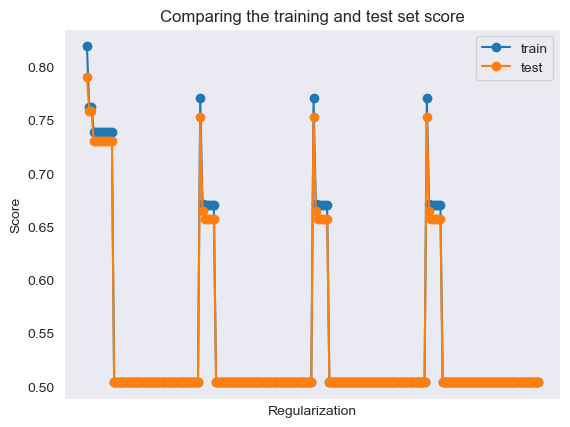

In [24]:
features = [None,'auto','sqrt','log2']     
ccps = np.arange(0, 0.5, 0.01)
clfs = []
for feature in features:
    for ccp in ccps:
        clf = DecisionTreeClassifier(random_state=0,
                                      criterion='gini',
                                      splitter='best',
                                      max_leaf_nodes=56,
                                      max_depth=8,
                                      ccp_alpha=ccp,
                                      max_features=feature
                                    )
        clf.fit(X_train, y_train)
        clfs.append(clf)
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

# Plot the results
fig, ax = plt.subplots()
ax.set_xlabel("Regularization")
ax.set_ylabel("Score")
ax.set_title("Comparing the training and test set score")

labels = [f"({feature},{ccp})" for feature in features for ccp in ccps]

ax.plot(labels, train_scores, marker='o', label="train")
ax.plot(labels, test_scores, marker='o', label="test")
ax.legend()
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.show()

In [25]:
best_score_index = np.argmax(test_scores)
best_params = {
    'max_features': features[best_score_index // len(ccps)],
    'ccp_alpha': ccps[best_score_index % len(ccps)]
}
print("Best Parameters:", best_params)

Best Parameters: {'max_features': None, 'ccp_alpha': 0.0}


We see that the tree performs best when it is not pruned thus we will continue as is

In [26]:
final_tuned_model = DecisionTreeClassifier(random_state=0,
                                           criterion='gini',
                                           splitter='best',
                                           max_leaf_nodes=56,
                                           max_depth=8
                                         )
final_tuned_model.fit(X_train,y_train)
cv_scores = cross_val_score(final_tuned_model, X_train, y_train, cv=10)
print("Cross-Validation Scores:", cv_scores)
print('Training Scores:',final_tuned_model.score(X_train, y_train))
print('Testing Scores:',final_tuned_model.score(X_test, y_test))
print('Average Croos-Validation Score:', cv_scores.mean())
print('-------------------------------------------------')
print('Final Model Metrics: ')
features = pd.concat([df_scaled,df_encoded,df_ohe],axis=1)
y_pred = final_tuned_model.predict(features)
print(f'Accuracy Score: {accuracy_score(targets,y_pred):.4f}')
print(f'Precision Score:{ precision_score(targets,y_pred):.4f}')
print(f'F1 Score: {f1_score(targets,y_pred):.4f}')
print('-------------------------------------------------')
cm = confusion_matrix(targets, y_pred)
print('Confusion Matrix :')
print(cm)
print('-------------------------------------------------')

Cross-Validation Scores: [0.78735632 0.78304598 0.81178161 0.73275862 0.79136691 0.77697842
 0.77266187 0.80143885 0.8        0.77410072]
Training Scores: 0.8192407247627265
Testing Scores: 0.7906843013225991
Average Croos-Validation Score: 0.783148929132556
-------------------------------------------------
Final Model Metrics: 
Accuracy Score: 0.8135
Precision Score:0.8213
F1 Score: 0.8130
-------------------------------------------------
Confusion Matrix :
[[3548  767]
 [ 854 3524]]
-------------------------------------------------


In [27]:
#mlp = MLPClassifier(random_state=0, early_stopping=True,validation_fraction=0.1)
mlp = MLPClassifier(random_state=0)
mlp.fit(X_train,y_train)
y_pred = mlp.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test,y_pred):.4f}')
print(f'Precision Score:{ precision_score(y_test,y_pred):.4f}')
print(f'F1 Score: {f1_score(y_test,y_pred):.4f}')
print('-------------------------------------------------')
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix :')
print(cm)
print('-------------------------------------------------')

Accuracy Score: 0.7936
Precision Score:0.7801
F1 Score: 0.8004
-------------------------------------------------
Confusion Matrix :
[[660 203]
 [156 720]]
-------------------------------------------------


We see that the basic MLP model underperforms the best iteration of our decision tree thus we will need to tune the hyperparameters to justify using using an extensive model over the decision tree

##### To tune the model this time we will be using GridSearch CV and printing out the results
- 1. Get the best solver parameters
- 2. FIguring our how expansive to make the laters
- 3. Setting the learning parameters
- 4. Regularization settings
- 5. Early stopping parameters

In [16]:
solver_params = {
    'solver': ['sgd', 'adam'],
    'activation': ['logistic', 'tanh', 'relu'],
}

solver_grid_search = GridSearchCV(MLPClassifier(random_state=0), solver_params, scoring='f1', cv=5)
solver_grid_search.fit(X_train, y_train)

print("Step 1: Best Solver Parameters")
print("Best Parameters:", solver_grid_search.best_params_)
print("Best F1 Score:", solver_grid_search.best_score_)
print("-------------------------------------------------")


Step 1: Best Solver Parameters
Best Parameters: {'activation': 'logistic', 'solver': 'adam'}
Best F1 Score: 0.7966992598903857
-------------------------------------------------


In [17]:
solver_grid_search_results = solver_grid_search.cv_results_
f1_scores = solver_grid_search_results['mean_test_score']
solver_values = solver_grid_search_results['param_solver']
activation_values = solver_grid_search_results['param_activation']
for solver, activation, f1_score in zip(solver_values, activation_values, f1_scores):
    print(f"Solver: {solver}, Activation: {activation}, F1 Score: {f1_score:.4f}")


Solver: sgd, Activation: logistic, F1 Score: 0.7474
Solver: adam, Activation: logistic, F1 Score: 0.7961
Solver: sgd, Activation: tanh, F1 Score: 0.7961
Solver: adam, Activation: tanh, F1 Score: 0.7964
Solver: sgd, Activation: relu, F1 Score: 0.7963
Solver: adam, Activation: relu, F1 Score: 0.7963


In [ ]:
layer_params = {
    'hidden_layer_sizes': list(product(range(0, 100, 20), repeat=3)),
}

layer_grid_search = GridSearchCV(MLPClassifier(random_state=0, 
                                               solver=solver_grid_search.best_params_['solver'],
                                               activation=solver_grid_search.best_params_['activation']),
                                               layer_params, scoring='f1', cv=5)
layer_grid_search.fit(X_train, y_train)

print("Step 2: Best Layer Parameters")
print("Best Parameters:", layer_grid_search.best_params_)
print("Best F1 Score:", layer_grid_search.best_score_)
print("-------------------------------------------------")


Step 2: Best Layer Parameters
Best Parameters: {'hidden_layer_sizes': (80, 40, 40)}
Best F1 Score: 0.8008550090010385
-------------------------------------------------


In [31]:
layer_grid_search_results = layer_grid_search.cv_results_
f1_scores = layer_grid_search_results['mean_test_score']
layer_values = layer_grid_search_results['param_hidden_layer_sizes']
for layer_values, f1_score in zip(layer_values, f1_scores):
    print(f"Layer Sizes: {layer_values}, F1 Score: {f1_score:.4f}")

Layer Sizes: (0, 0, 0), F1 Score: nan
Layer Sizes: (0, 0, 20), F1 Score: nan
Layer Sizes: (0, 0, 40), F1 Score: nan
Layer Sizes: (0, 0, 60), F1 Score: nan
Layer Sizes: (0, 0, 80), F1 Score: nan
Layer Sizes: (0, 20, 0), F1 Score: nan
Layer Sizes: (0, 20, 20), F1 Score: nan
Layer Sizes: (0, 20, 40), F1 Score: nan
Layer Sizes: (0, 20, 60), F1 Score: nan
Layer Sizes: (0, 20, 80), F1 Score: nan
Layer Sizes: (0, 40, 0), F1 Score: nan
Layer Sizes: (0, 40, 20), F1 Score: nan
Layer Sizes: (0, 40, 40), F1 Score: nan
Layer Sizes: (0, 40, 60), F1 Score: nan
Layer Sizes: (0, 40, 80), F1 Score: nan
Layer Sizes: (0, 60, 0), F1 Score: nan
Layer Sizes: (0, 60, 20), F1 Score: nan
Layer Sizes: (0, 60, 40), F1 Score: nan
Layer Sizes: (0, 60, 60), F1 Score: nan
Layer Sizes: (0, 60, 80), F1 Score: nan
Layer Sizes: (0, 80, 0), F1 Score: nan
Layer Sizes: (0, 80, 20), F1 Score: nan
Layer Sizes: (0, 80, 40), F1 Score: nan
Layer Sizes: (0, 80, 60), F1 Score: nan
Layer Sizes: (0, 80, 80), F1 Score: nan
Layer Size

In [19]:
learning_params = {
    'learning_rate_init': np.arange(0.001,0.5,0.05),
}

learning_grid_search = GridSearchCV(MLPClassifier(random_state=0, 
                                                solver=solver_grid_search.best_params_['solver'],
                                                activation=solver_grid_search.best_params_['activation'],
                                                hidden_layer_sizes=(80, 40, 40)),
                                                learning_params,
                                                scoring='f1_weighted', 
                                                cv=5)
learning_grid_search.fit(X_train, y_train)

print("Step 3: Best Learning Parameters")
print("Best Parameters:", learning_grid_search.best_params_)
print("Best F1 Score:", learning_grid_search.best_score_)
print("-------------------------------------------------")


Step 3: Best Learning Parameters
Best Parameters: {'learning_rate_init': 0.001}
Best F1 Score: 0.7873679037641501
-------------------------------------------------


In [20]:
learning_grid_search_results = learning_grid_search.cv_results_
f1_scores = learning_grid_search_results['mean_test_score']
learning_values = learning_grid_search_results['param_learning_rate_init']
for learning_value, f1_score in zip(learning_values, f1_scores):
    print(f"Initial Learning Rate: {learning_value}, F1 Score: {f1_score:.4f}")

Initial Learning Rate: 0.001, F1 Score: 0.7874
Initial Learning Rate: 0.051000000000000004, F1 Score: 0.7730
Initial Learning Rate: 0.101, F1 Score: 0.7796
Initial Learning Rate: 0.15100000000000002, F1 Score: 0.6823
Initial Learning Rate: 0.201, F1 Score: 0.5033
Initial Learning Rate: 0.251, F1 Score: 0.3325
Initial Learning Rate: 0.30100000000000005, F1 Score: 0.3340
Initial Learning Rate: 0.35100000000000003, F1 Score: 0.3340
Initial Learning Rate: 0.401, F1 Score: 0.3356
Initial Learning Rate: 0.451, F1 Score: 0.3338


In [22]:
learning_params = {
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'power_t': np.arange(0,1,0.1),
}

learning_grid_search2 = GridSearchCV(MLPClassifier(random_state=0, 
                                                solver=solver_grid_search.best_params_['solver'],
                                                activation=solver_grid_search.best_params_['activation'],
                                                hidden_layer_sizes= (80, 40, 40),
                                                learning_rate_init= learning_grid_search.best_params_['learning_rate_init']),
                                                learning_params,
                                                scoring='f1_weighted', 
                                                cv=5)
learning_grid_search2.fit(X_train, y_train)

print("Step 3.2: Best Learning Parameters")
print("Best Parameters:", learning_grid_search2.best_params_)
print("Best F1 Score:", learning_grid_search2.best_score_)
print("-------------------------------------------------")
learning_grid_search_results = learning_grid_search2.cv_results_
f1_scores = learning_grid_search_results['mean_test_score']
learning_rates = learning_grid_search_results['param_learning_rate']
power_t_values = learning_grid_search_results['param_power_t']
for learning_rate,power_t_value, f1_score in zip(learning_rates,power_t_values, f1_scores):
    print(f"Learning Rate: {learning_rate}, F1 Score: {f1_score:.4f}")
    print(f"Power T value: {power_t_value}, F1 Score: {f1_score:.4f}")

Step 3.2: Best Learning Parameters
Best Parameters: {'learning_rate': 'constant', 'power_t': 0.0}
Best F1 Score: 0.7873679037641501
-------------------------------------------------
Layer Sizes: constant, F1 Score: 0.7874
Layer Sizes: 0.0, F1 Score: 0.7874
Layer Sizes: constant, F1 Score: 0.7874
Layer Sizes: 0.1, F1 Score: 0.7874
Layer Sizes: constant, F1 Score: 0.7874
Layer Sizes: 0.2, F1 Score: 0.7874
Layer Sizes: constant, F1 Score: 0.7874
Layer Sizes: 0.30000000000000004, F1 Score: 0.7874
Layer Sizes: constant, F1 Score: 0.7874
Layer Sizes: 0.4, F1 Score: 0.7874
Layer Sizes: constant, F1 Score: 0.7874
Layer Sizes: 0.5, F1 Score: 0.7874
Layer Sizes: constant, F1 Score: 0.7874
Layer Sizes: 0.6000000000000001, F1 Score: 0.7874
Layer Sizes: constant, F1 Score: 0.7874
Layer Sizes: 0.7000000000000001, F1 Score: 0.7874
Layer Sizes: constant, F1 Score: 0.7874
Layer Sizes: 0.8, F1 Score: 0.7874
Layer Sizes: constant, F1 Score: 0.7874
Layer Sizes: 0.9, F1 Score: 0.7874
Layer Sizes: invscalin

In [23]:
reg_params = {
    'alpha': [0.0001, 0.001, 0.01],
    'beta_1': [0.8, 0.9, 0.99],
    'beta_2': [0.8, 0.9, 0.999],
}

reg_grid_search = GridSearchCV(MLPClassifier(random_state=0, 
                                                solver=solver_grid_search.best_params_['solver'],
                                                activation=solver_grid_search.best_params_['activation'],
                                                hidden_layer_sizes= (80, 40, 40),
                                                learning_rate_init= 0.001,
                                                learning_rate=learning_grid_search2.best_params_['learning_rate'],
                                                power_t = learning_grid_search2.best_params_['power_t']),
                                                reg_params, scoring='f1_weighted', cv=5)
reg_grid_search.fit(X_train, y_train)

print("Step 4: Best Regularization Parameters")
print("Best Parameters:", reg_grid_search.best_params_)
print("Best F1 Score:", reg_grid_search.best_score_)
print("-------------------------------------------------")


Step 4: Best Regularization Parameters
Best Parameters: {'alpha': 0.001, 'beta_1': 0.99, 'beta_2': 0.8}
Best F1 Score: 0.7911815293779402
-------------------------------------------------


KeyError: 'alpha'

In [24]:
reg_grid_search_results = reg_grid_search.cv_results_
f1_scores = reg_grid_search_results['mean_test_score']
alpha_values = reg_grid_search_results['param_alpha']
beta_1_values = reg_grid_search_results['param_beta_1']
beta_2_values = reg_grid_search_results['param_beta_2']
for alpha_value, beta_1_value, beta_2_value, f1_score in zip(alpha_values,beta_1_values,beta_2_values, f1_scores):
    print(f"Learning Rate: {alpha_value}, F1 Score: {f1_score:.4f}")
    print(f"Power T value: {beta_1_value}, F1 Score: {f1_score:.4f}")
    print(f"Power T value: {beta_2_value}, F1 Score: {f1_score:.4f}")

Learning Rate: 0.0001, F1 Score: 0.7885
Power T value: 0.8, F1 Score: 0.7885
Power T value: 0.8, F1 Score: 0.7885
Learning Rate: 0.0001, F1 Score: 0.7883
Power T value: 0.8, F1 Score: 0.7883
Power T value: 0.9, F1 Score: 0.7883
Learning Rate: 0.0001, F1 Score: 0.7866
Power T value: 0.8, F1 Score: 0.7866
Power T value: 0.999, F1 Score: 0.7866
Learning Rate: 0.0001, F1 Score: 0.7855
Power T value: 0.9, F1 Score: 0.7855
Power T value: 0.8, F1 Score: 0.7855
Learning Rate: 0.0001, F1 Score: 0.7821
Power T value: 0.9, F1 Score: 0.7821
Power T value: 0.9, F1 Score: 0.7821
Learning Rate: 0.0001, F1 Score: 0.7874
Power T value: 0.9, F1 Score: 0.7874
Power T value: 0.999, F1 Score: 0.7874
Learning Rate: 0.0001, F1 Score: 0.7903
Power T value: 0.99, F1 Score: 0.7903
Power T value: 0.8, F1 Score: 0.7903
Learning Rate: 0.0001, F1 Score: 0.7910
Power T value: 0.99, F1 Score: 0.7910
Power T value: 0.9, F1 Score: 0.7910
Learning Rate: 0.0001, F1 Score: 0.7899
Power T value: 0.99, F1 Score: 0.7899
Powe

In [27]:
X_train.shape[0]

6954

In [28]:
#mlp = MLPClassifier(random_state=0, early_stopping=True,validation_fraction=0.1)
reg_params2 = {
    'early_stopping': [True, False],
    'validation_fraction': np.arange(0.1,0.251,0.05),
    'batch_size': np.arange(200,X_train.shape[0],1340)
}

reg_grid_search2 = GridSearchCV(MLPClassifier(random_state=0, 
                                                solver=solver_grid_search.best_params_['solver'],
                                                activation=solver_grid_search.best_params_['activation'],
                                                hidden_layer_sizes= (80, 40, 40),
                                                learning_rate_init= 0.001,
                                                learning_rate=learning_grid_search2.best_params_['learning_rate'],
                                                power_t = learning_grid_search2.best_params_['power_t'],
                                                alpha = reg_grid_search.best_params_['alpha'],
                                                beta_1 = reg_grid_search.best_params_['beta_1'],
                                                beta_2 = reg_grid_search.best_params_['beta_2']),
                                                reg_params2, scoring='f1_weighted', cv=5)
reg_grid_search2.fit(X_train, y_train)

print("Step 4: Best Regularization Parameters")
print("Best Parameters:", reg_grid_search2.best_params_)
print("Best F1 Score:", reg_grid_search2.best_score_)
print("-------------------------------------------------")


Step 4: Best Regularization Parameters
Best Parameters: {'batch_size': 200, 'early_stopping': False, 'validation_fraction': 0.1}
Best F1 Score: 0.7911815293779402
-------------------------------------------------
Learning Rate: 0.01, F1 Score: 0.7715
Power T value: 0.99, F1 Score: 0.7715
Power T value: 0.999, F1 Score: 0.7715
Learning Rate: 0.01, F1 Score: 0.7836
Power T value: 0.99, F1 Score: 0.7836
Power T value: 0.999, F1 Score: 0.7836
Learning Rate: 0.01, F1 Score: 0.7796
Power T value: 0.99, F1 Score: 0.7796
Power T value: 0.999, F1 Score: 0.7796
Learning Rate: 0.01, F1 Score: 0.7787
Power T value: 0.99, F1 Score: 0.7787
Power T value: 0.999, F1 Score: 0.7787
Learning Rate: 0.01, F1 Score: 0.7912
Power T value: 0.99, F1 Score: 0.7912
Power T value: 0.999, F1 Score: 0.7912
Learning Rate: 0.01, F1 Score: 0.7912
Power T value: 0.99, F1 Score: 0.7912
Power T value: 0.999, F1 Score: 0.7912
Learning Rate: 0.01, F1 Score: 0.7912
Power T value: 0.99, F1 Score: 0.7912
Power T value: 0.999,

In [29]:
reg_grid_search_results = reg_grid_search2.cv_results_
f1_scores = reg_grid_search_results['mean_test_score']
early_stopping_values = reg_grid_search_results['param_early_stopping']
validation_fractions = reg_grid_search_results['param_validation_fraction']
batch_sizes = reg_grid_search_results['param_batch_size']
for early_stopping, validation_fraction, batch_size, f1_score in zip(early_stopping_values,validation_fractions,batch_sizes, f1_scores):
    print(f"Early Stopping: {early_stopping}, F1 Score: {f1_score:.4f}")
    print(f"Validation Size: {validation_fraction}, F1 Score: {f1_score:.4f}")
    print(f"Batch Size: {batch_size}, F1 Score: {f1_score:.4f}")

Early Stopping: True, F1 Score: 0.7715
Validation Size: 0.1, F1 Score: 0.7715
Batch Size: 200, F1 Score: 0.7715
Early Stopping: True, F1 Score: 0.7836
Validation Size: 0.15000000000000002, F1 Score: 0.7836
Batch Size: 200, F1 Score: 0.7836
Early Stopping: True, F1 Score: 0.7796
Validation Size: 0.20000000000000004, F1 Score: 0.7796
Batch Size: 200, F1 Score: 0.7796
Early Stopping: True, F1 Score: 0.7787
Validation Size: 0.25000000000000006, F1 Score: 0.7787
Batch Size: 200, F1 Score: 0.7787
Early Stopping: False, F1 Score: 0.7912
Validation Size: 0.1, F1 Score: 0.7912
Batch Size: 200, F1 Score: 0.7912
Early Stopping: False, F1 Score: 0.7912
Validation Size: 0.15000000000000002, F1 Score: 0.7912
Batch Size: 200, F1 Score: 0.7912
Early Stopping: False, F1 Score: 0.7912
Validation Size: 0.20000000000000004, F1 Score: 0.7912
Batch Size: 200, F1 Score: 0.7912
Early Stopping: False, F1 Score: 0.7912
Validation Size: 0.25000000000000006, F1 Score: 0.7912
Batch Size: 200, F1 Score: 0.7912
Earl

In [30]:

# Step 5: Early stopping parameters
early_stop_params = {
    'n_iter_no_change': [2,5,10],
    'tol': [1e-3, 1e-4, 1e-5],
}

early_stop_grid_search = GridSearchCV(MLPClassifier(random_state=0,  
                                                solver=solver_grid_search.best_params_['solver'],
                                                activation=solver_grid_search.best_params_['activation'],
                                                hidden_layer_sizes= (80, 40, 40),
                                                learning_rate_init= 0.001,
                                                learning_rate=learning_grid_search2.best_params_['learning_rate'],
                                                power_t = learning_grid_search2.best_params_['power_t'],
                                                alpha = reg_grid_search.best_params_['alpha'],
                                                beta_1 = reg_grid_search.best_params_['beta_1'],
                                                beta_2 = reg_grid_search.best_params_['beta_2'],
                                                early_stopping = True),
                                                early_stop_params, scoring='f1', cv=5)
early_stop_grid_search.fit(X_train, y_train)

print("Step 5: Best Early Stopping Parameters")
print("Best Parameters:", early_stop_grid_search.best_params_)
print("Best F1 Score:", early_stop_grid_search.best_score_)
print("-------------------------------------------------")


Step 5: Best Early Stopping Parameters
Best Parameters: {'n_iter_no_change': 10, 'tol': 0.001}
Best F1 Score: 0.775045793387077
-------------------------------------------------


In [34]:
from sklearn.metrics import f1_score

In [35]:
best_mlp_model = MLPClassifier( random_state=0,  
                                solver=solver_grid_search.best_params_['solver'],
                                activation=solver_grid_search.best_params_['activation'],
                                hidden_layer_sizes= (80, 40, 40),
                                learning_rate_init= 0.001,
                                learning_rate=learning_grid_search2.best_params_['learning_rate'],
                                power_t = learning_grid_search2.best_params_['power_t'],
                                alpha = reg_grid_search.best_params_['alpha'],
                                beta_1 = reg_grid_search.best_params_['beta_1'],
                                beta_2 = reg_grid_search.best_params_['beta_2'],
                                tol=early_stop_grid_search.best_params_['tol'],)

best_mlp_model.fit(X_train, y_train)
test_predictions = best_mlp_model.predict(X_test)
test_f1_score = f1_score(y_test, test_predictions, average='weighted')
cv_scores = cross_val_score(best_mlp_model, X_train, y_train, cv=10)
print("Cross-Validation Scores:", cv_scores)
print('Training Scores:',best_mlp_model.score(X_train, y_train))
print('Testing Scores:',best_mlp_model.score(X_test, y_test))
print('Average Croos-Validation Score:', cv_scores.mean())
print('-------------------------------------------------')
print('Final Model Metrics: ')
y_pred = best_mlp_model.predict(features)
print(f'Accuracy Score: {accuracy_score(targets,y_pred):.4f}')
print(f'Precision Score:{ precision_score(targets,y_pred):.4f}')
print(f'F1 Score: {f1_score(targets,y_pred):.4f}')
print('-------------------------------------------------')
cm = confusion_matrix(targets, y_pred)
print('Confusion Matrix :')
print(cm)
print('-------------------------------------------------')


mlp = MLPClassifier(random_state=0)
mlp.fit(X_train,y_train)
y_pred = mlp.predict(X_test)
print('Initial Model Metrics: ')
y_pred = mlp.predict(features)
print(f'Accuracy Score: {accuracy_score(targets,y_pred):.4f}')
print(f'Precision Score:{ precision_score(targets,y_pred):.4f}')
print(f'F1 Score: {f1_score(targets,y_pred):.4f}')
print('-------------------------------------------------')
cm = confusion_matrix(targets, y_pred)
print('Confusion Matrix :')
print(cm)
print('-------------------------------------------------')

Cross-Validation Scores: [0.80028736 0.8045977  0.79597701 0.76724138 0.78705036 0.78417266
 0.76115108 0.79856115 0.80863309 0.79136691]
Training Scores: 0.7920621225194133
Testing Scores: 0.7860839562967222
Average Croos-Validation Score: 0.7899038700074424
-------------------------------------------------
Final Model Metrics: 
Accuracy Score: 0.7909
Precision Score:0.7818
F1 Score: 0.7962
-------------------------------------------------
Confusion Matrix :
[[3324  991]
 [ 827 3551]]
-------------------------------------------------
Initial Model Metrics: 
Accuracy Score: 0.8148
Precision Score:0.8059
F1 Score: 0.8191
-------------------------------------------------
Confusion Matrix :
[[3437  878]
 [ 732 3646]]
-------------------------------------------------


Now that we have built 4 models (a basic and a tuned version of each model) we will now render csv submissions for all unto kaggle and see how each model performs on the public leaderboard


In [40]:
clf = DecisionTreeClassifier(
                            criterion='log_loss',
                            splitter='best',
                            random_state=0
                            )
clf.fit(X_train,y_train)

final_tuned_model = DecisionTreeClassifier(random_state=0,
                                           criterion='gini',
                                           splitter='best',
                                           max_leaf_nodes=56,
                                           max_depth=8
                                         )
final_tuned_model.fit(X_train,y_train)


DecisionTreeClassifier(max_depth=8, max_leaf_nodes=56, random_state=0)

In [47]:
predictions_basic_dt  = clf.predict(test_features).astype(bool)
predictions_tuned_dt = final_tuned_model.predict(test_features).astype(bool)
predictions_basic_mlp = mlp.predict(test_features).astype(bool)
predictions_tuned_mlp = best_mlp_model.predict(test_features).astype(bool)

submission_basic_dt = pd.DataFrame({'PassengerId': test_features.index, 'Transported': predictions_basic_dt})
submission_tuned_dt = pd.DataFrame({'PassengerId': test_features.index, 'Transported': predictions_tuned_dt})
submission_basic_mlp = pd.DataFrame({'PassengerId': test_features.index, 'Transported': predictions_basic_mlp})
submission_tuned_mlp = pd.DataFrame({'PassengerId': test_features.index, 'Transported': predictions_tuned_mlp})

submission_basic_dt.to_csv('submission_basic_decision_tree.csv', index=False)
submission_tuned_dt.to_csv('submission_tuned_decision_tree.csv', index=False)
submission_basic_mlp.to_csv('submission_basic_mlp.csv', index=False)
submission_tuned_mlp.to_csv('submission_tuned_mlp.csv', index=False)


In [48]:
submission_basic_dt

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [49]:
submission_tuned_dt

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


In [50]:
submission_basic_mlp

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [51]:
submission_tuned_mlp

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


For Context I will build the model on XGB with the unclean data and XGB on the clean data

Clean data version

In [52]:
import xgboost as xgb
model_xgb = xgb.XGBClassifier(random_state=0)
model_xgb.fit(X_train, y_train)
cv_scores = cross_val_score(model_xgb, X_train, y_train, cv=10)
print("Cross-Validation Scores:", cv_scores)
print('Training Scores:',model_xgb.score(X_train, y_train))
print('Testing Scores:',model_xgb.score(X_test, y_test))
print('Average Croos-Validation Score:', cv_scores.mean())
y_pred = model_xgb.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test,y_pred):.4f}')
print(f'Precision Score:{ precision_score(y_test,y_pred):.4f}')
print(f'F1 Score: {f1_score(y_test,y_pred):.4f}')
print('-------------------------------------------------')
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix :')
print(cm)
print('-------------------------------------------------')
print('Final Model Metrics: ')
y_pred = model_xgb.predict(features)
print(f'Accuracy Score: {accuracy_score(targets,y_pred):.4f}')
print(f'Precision Score:{ precision_score(targets,y_pred):.4f}')
print(f'F1 Score: {f1_score(targets,y_pred):.4f}')
print('-------------------------------------------------')
cm = confusion_matrix(targets, y_pred)
print('Confusion Matrix :')
print(cm)
print('-------------------------------------------------')


Cross-Validation Scores: [0.81465517 0.79166667 0.80028736 0.77298851 0.78705036 0.80431655
 0.78561151 0.8        0.81151079 0.79856115]
Training Scores: 0.9388840954846132
Testing Scores: 0.8159861989649224
Average Croos-Validation Score: 0.7966648060861655
Accuracy Score: 0.8160
Precision Score:0.8152
F1 Score: 0.8180
-------------------------------------------------
Confusion Matrix :
[[700 163]
 [157 719]]
-------------------------------------------------
Final Model Metrics: 
Accuracy Score: 0.9143
Precision Score:0.9077
F1 Score: 0.9157
-------------------------------------------------
Confusion Matrix :
[[3904  411]
 [ 334 4044]]
-------------------------------------------------


In [53]:
predictions_basic_xgb  = model_xgb.predict(test_features).astype(bool)
submission_basic_xgb = pd.DataFrame({'PassengerId': test_features.index, 'Transported': predictions_basic_xgb})
submission_basic_xgb.to_csv('submission_xgb_clean.csv', index=False)

In [56]:
model_xgb = xgb.XGBClassifier(
    learning_rate = 0.1,
    max_dephth = 15,
    n_estimators = 200,
    sampling_method = 'uniform',
    objective='binary:logistic',  
    eval_metric='logloss',
    grow_policy = 'depthwise', 
    tree_method = 'exact',
    updater = 'grow_histmaker',
    reg_alpha = 0.5, 
    reg_lambda = 0.01,
    verbosity = 2,
    nthread = -1,
    random_state=0
)
model_xgb.fit(X_train,y_train)
cv_scores = cross_val_score(model_xgb, X_train, y_train, cv=10)
print("Cross-Validation Scores:", cv_scores)
print('Training Scores:',model_xgb.score(X_train, y_train))
print('Testing Scores:',model_xgb.score(X_test, y_test))
print('Average Croos-Validation Score:', cv_scores.mean())
y_pred = model_xgb.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test,y_pred):.4f}')
print(f'Precision Score:{ precision_score(y_test,y_pred):.4f}')
print(f'F1 Score: {f1_score(y_test,y_pred):.4f}')
print('-------------------------------------------------')
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix :')
print(cm)
print('-------------------------------------------------')
print('Final Model Metrics: ')
y_pred = model_xgb.predict(features)
print(f'Accuracy Score: {accuracy_score(targets,y_pred):.4f}')
print(f'Precision Score:{ precision_score(targets,y_pred):.4f}')
print(f'F1 Score: {f1_score(targets,y_pred):.4f}')
print('-------------------------------------------------')
cm = confusion_matrix(targets, y_pred)
print('Confusion Matrix :')
print(cm)
print('-------------------------------------------------')

Cross-Validation Scores: [0.8045977  0.79741379 0.80603448 0.77298851 0.8028777  0.80143885
 0.8057554  0.81151079 0.80863309 0.79856115]
Training Scores: 0.9272361230946218
Testing Scores: 0.8159861989649224
Average Croos-Validation Score: 0.8009811461175887
Accuracy Score: 0.8160
Precision Score:0.8159
F1 Score: 0.8178
-------------------------------------------------
Confusion Matrix :
[[701 162]
 [158 718]]
-------------------------------------------------
Final Model Metrics: 
Accuracy Score: 0.9050
Precision Score:0.9020
F1 Score: 0.9061
-------------------------------------------------
Confusion Matrix :
[[3882  433]
 [ 393 3985]]
-------------------------------------------------


In [57]:
predictions_basic_xgb  = model_xgb.predict(test_features).astype(bool)
submission_basic_xgb = pd.DataFrame({'PassengerId': test_features.index, 'Transported': predictions_basic_xgb})
submission_basic_xgb.to_csv('submission_xgb_2.csv', index=False)